In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Reshape, BatchNormalization, LeakyReLU, Conv2D, Conv2DTranspose
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

Data preprocessing

In [2]:
def load_images_from_folder(folder, target_size=(64, 64), max_images=1000):
    images = []
    for i, filename in enumerate(os.listdir(folder)):
        if i >= max_images:
            break
        img = load_img(os.path.join(folder, filename), target_size=target_size)
        if img is not None:
            images.append(img_to_array(img))
    images = np.array(images)
    images = (images - 127.5) / 127.5  # Normalize images to [-1, 1]
    return images

dataset_path = 'dataset/casual_men_winter'
images = load_images_from_folder(dataset_path, max_images=100)

GAN MODEL

In [3]:
def build_generator():
    model = Sequential()
    model.add(Dense(256 * 8 * 8, activation="relu", input_dim=100))
    model.add(Reshape((8, 8, 256)))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"))  # 16x16x128
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Conv2DTranspose(64, kernel_size=4, strides=2, padding="same"))  # 32x32x64
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Conv2DTranspose(32, kernel_size=4, strides=2, padding="same"))  # 64x64x32
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(3, kernel_size=3, padding="same", activation='tanh'))  # 64x64x3
    return model


def build_discriminator():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=(64, 64, 3), padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model



Compile the model

In [4]:
def compile_gan(generator, discriminator):
    discriminator.trainable = False
    gan_input = tf.keras.Input(shape=(100,))
    generated_image = generator(gan_input)
    gan_output = discriminator(generated_image)
    gan = tf.keras.Model(gan_input, gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))
    return gan

Train the GAN model

In [5]:
def train_gan(generator, discriminator, gan, images, epochs=1000, batch_size=32, save_interval=200):
    half_batch = batch_size // 2

    for epoch in range(epochs):
        idx = np.random.randint(0, images.shape[0], half_batch)
        real_images = images[idx]
        noise = np.random.normal(0, 1, (half_batch, 100))
        fake_images = generator.predict(noise)

        real_labels = np.ones((half_batch, 1))
        fake_labels = np.zeros((half_batch, 1))

        d_loss_real = discriminator.train_on_batch(real_images, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        noise = np.random.normal(0, 1, (batch_size, 100))
        valid_labels = np.ones((batch_size, 1))

        g_loss = gan.train_on_batch(noise, valid_labels)

        if epoch % save_interval == 0:
            print(f"{epoch} [D loss: {d_loss[0]} | D accuracy: {d_loss[1]*100}%] [G loss: {g_loss}]")
            save_images(generator, epoch)
            
def save_images(generator, epoch, image_grid_rows=2, image_grid_columns=2):
    noise = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, 100))
    generated_images = generator.predict(noise)
    generated_images = 0.5 * generated_images + 0.5

    fig, axs = plt.subplots(image_grid_rows, image_grid_columns, figsize=(5, 5))
    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            axs[i,j].imshow(generated_images[cnt, :,:,:])
            axs[i,j].axis('off')
            cnt += 1
    plt.show()

Executing the gan model

c:\Users\Shreyas Dixit\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Shreyas Dixit\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
c:\Users\Shreyas Dixit\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


c:\Users\Shreyas Dixit\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py:77: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


0 [D loss: 0.7095575928688049 | D accuracy: 37.5%] [G loss: 0.720669150352478]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


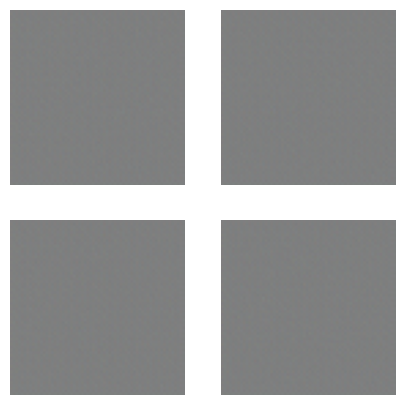

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━

KeyboardInterrupt: 

In [6]:
generator = build_generator()
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])
gan = compile_gan(generator, discriminator)

train_gan(generator, discriminator, gan, images, epochs=1000, batch_size=32, save_interval=200)